<a href="https://colab.research.google.com/github/edgeemer/hillel_ml_2025/blob/main/HW%206.%20Nmist%20unsing%20deep%20learning/mnist_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# clean cache
# !rm -rf t*.gz

# download dataset
# !echo "Loadig..."
# !wget http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz
# !wget http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz
# !wget http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz
# !wget http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz

In [ ]:
# Alternative download

"""
import torch
import torchvision
from torchvision.datasets import MNIST

# Download training dataset
dataset = MNIST(root='/content/', download=True)
"""

"\nimport torch\nimport torchvision\nfrom torchvision.datasets import MNIST\n\n# Download training dataset\ndataset = MNIST(root='/content/', download=True)\n"

In [1]:
import os
import sys
import gzip
import struct
from typing import List

import numpy as np
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt

In [2]:
def read_images_archive(fi):
    magic, n, rows, columns = struct.unpack(">IIII", fi.read(16))
    assert magic == 0x00000803
    assert rows == 28
    assert columns == 28
    rawbuffer = fi.read()
    assert len(rawbuffer) == n * rows * columns
    rawdata = np.frombuffer(rawbuffer, dtype='>u1', count=n * rows * columns)
    return rawdata.reshape(n, rows, columns).astype(np.float32) / 255.0

def read_labels_archive(fi):
    magic, n = struct.unpack(">II", fi.read(8))
    assert magic == 0x00000801
    rawbuffer = fi.read()
    assert len(rawbuffer) == n
    return np.frombuffer(rawbuffer, dtype='>u1', count=n)

In [3]:
with gzip.open("train-images-idx3-ubyte.gz", "rb") as fp:
    train_images = read_images_archive(fp)
    print(f"Loaded training images with shape {train_images.shape}!")

with gzip.open("train-labels-idx1-ubyte.gz", "rb") as fp:
    train_labels = read_labels_archive(fp)
    print(f"Loaded training labels with shape {train_labels.shape}!")

with gzip.open("t10k-images-idx3-ubyte.gz", "rb") as fp:
    test_images = read_images_archive(fp)
    print(f"Loaded test images with shape {test_images.shape}!")

with gzip.open("t10k-labels-idx1-ubyte.gz", "rb") as fp:
    test_labels = read_labels_archive(fp)
    print(f"Loaded test labels with shape {test_labels.shape}!")

Loaded training images with shape (60000, 28, 28)!
Loaded training labels with shape (60000,)!
Loaded test images with shape (10000, 28, 28)!
Loaded test labels with shape (10000,)!


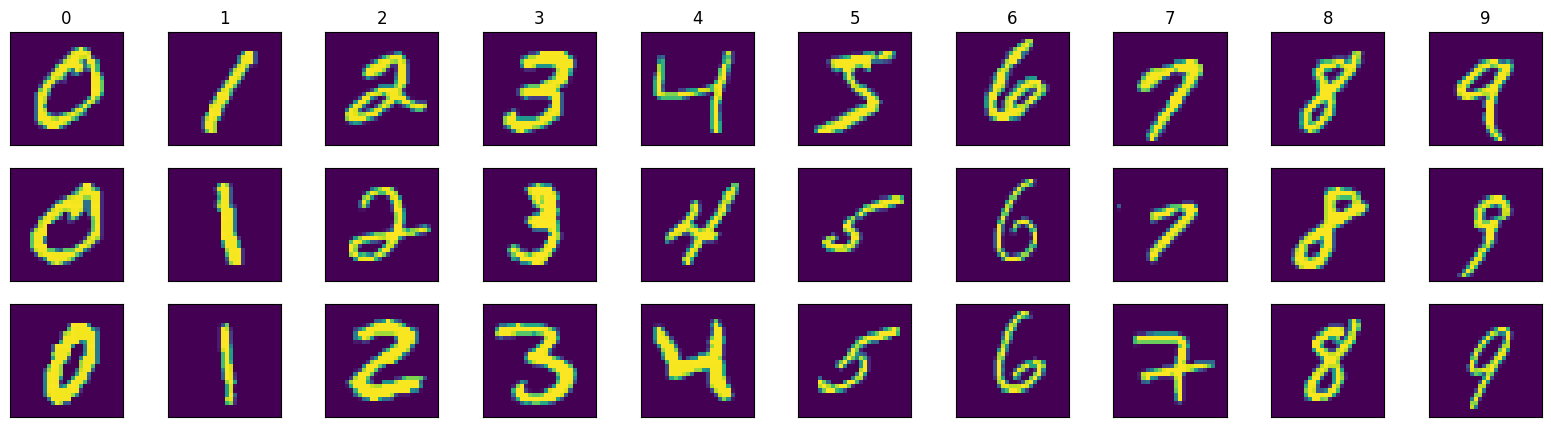

In [4]:
# NOTE: visualize training dataset
_nrows = 3
fig, axes = plt.subplots(nrows=_nrows, ncols=10, figsize=(20, 5))
for lbl in range(10):
    for r in range(_nrows):
        ax = axes[r][lbl]
        ax.imshow(train_images[train_labels == lbl][r])
        ax.xaxis.set_tick_params(labelbottom=False)
        ax.yaxis.set_tick_params(labelleft=False)
        ax.set_xticks([])
        ax.set_yticks([])
        if r == 0:
            ax.set_title(f"{lbl}")

In [5]:
# Linear

class MNISTDataset(Dataset):
    def __init__(self, images, labels) -> None:
        # Check if the number of images matches the number of labels
        if len(images) != len(labels):
            raise ValueError(f"Diffent number of images ({len(images)}) and labels ({len(labels)})!")

        # Store images and labels
        self.images = images
        self.labels = labels

    def __len__(self):
        # Return the total number of samples in the dataset
        return len(self.images)

    def __getitem__(self, index):
        # Normalize the image data to a range between 0 and 1
        image = (self.images[index] / 255.0).astype(np.float32)  # [0 .. 255] -> [0,1]

        # For convolutional models: uncomment the next line
        # image = image[None, ...]

        # For linear models: flatten the image
        image = image.flatten()

        # Retrieve the label for the current index
        label = self.labels[index]

        # Convert the image and label to PyTorch tensors
        image = torch.from_numpy(image)  # Convert to float32 tensor
        label = torch.LongTensor([label])  # Convert to long tensor

        return image, label

In [ ]:
# Standard architecture

class MLP(nn.Module):
    def __init__(self, nin: int, nouts: List[int]) -> None:
        # Initialize the MLP module
        super().__init__()

        # Define the sizes of the layers
        sizes = [nin] + nouts

        # Standard architecture
        self.layers = nn.ModuleList([nn.Linear(sizes[i], sizes[i + 1]) for i in range(len(nouts))])

        # Store the number of layers
        self.n_layers = len(self.layers)

    def forward(self, x: torch.FloatTensor) -> torch.FloatTensor:
        # Forward pass through the MLP
        for i, layer in enumerate(self.layers):
            x = layer(x)  # Apply the linear transformation

            # Apply activation function except for the last layer
            if i != self.n_layers - 1:
                x = F.relu(x)  # ReLU activation function

        return x  # Return the output of the last layer


# Function to initialize the parameters of a module
def init_parameters(module):
    # Check if the module is an instance of nn.Linear
    if isinstance(module, nn.Linear):
        # Initialize the weights of the linear module with uniform distribution between -1 and 1
        module.weight = torch.nn.init.uniform_(module.weight, -1, 1)

        # Initialize the bias of the linear module with zeros
        module.bias.data.fill_(0.0)

In [ ]:
# Reorganization into Sequential + adding dropout & normalization layers

class MLP(nn.Module):
    def __init__(self, nin: int, nouts: List[int]) -> None:
        super().__init__()
        sizes = [nin] + nouts
        self.layers = nn.ModuleList([
            nn.Sequential(
                nn.Linear(sizes[i], sizes[i + 1]),
                nn.BatchNorm1d(sizes[i + 1]),  # Training stabilization
                nn.ReLU(),
                nn.Dropout(p=0.2)
            ) for i in range(len(nouts))
        ])
        self.n_layers = len(self.layers)

    def forward(self, x: torch.FloatTensor) -> torch.FloatTensor:
        for layer in self.layers:
            x = layer(x)
        return x

def init_parameters(module):
    if isinstance(module, nn.Linear):
        module.weight = torch.nn.init.uniform_(module.weight, -1, 1)
        module.bias.data.fill_(0.0)
    elif isinstance(module, nn.BatchNorm1d):
        module.weight.data.fill_(1.0)  # BatchNorm weights to 1
        module.bias.data.fill_(0.0)    # BatchNorm biases to 0

In [14]:
# For CNN


class MNISTDataset(Dataset):
    def __init__(self, images, labels) -> None:
        # Check if the number of images matches the number of labels
        if len(images) != len(labels):
            raise ValueError(f"Diffent number of images ({len(images)}) and labels ({len(labels)})!")

        # Store images and labels
        self.images = images
        self.labels = labels

    def __len__(self):
        # Return the total number of samples in the dataset
        return len(self.images)

    def __getitem__(self, index):
        # Normalize the image data to a range between 0 and 1
        image = (self.images[index] / 255.0).astype(np.float32)  # [0 .. 255] -> [0,1]

        # For convolutional models: uncomment the next line
        image = image[None, ...]

        # For linear models: flatten the image
        # image = image.flatten()

        # Retrieve the label for the current index
        label = self.labels[index]

        # Convert the image and label to PyTorch tensors
        image = torch.from_numpy(image)  # Convert to float32 tensor
        label = torch.LongTensor([label])  # Convert to long tensor

        return image, label

In [15]:
# CNN insipred by CNN Explainer & online tutorials

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=5)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=5)
        self.fc1 = nn.Linear(3*3*64, 256)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = F.dropout(x, p=0.2, training=self.training)
        x = F.relu(F.max_pool2d(self.conv3(x),2))
        x = F.dropout(x, p=0.2, training=self.training)
        x = x.view(-1,3*3*64 )
        x = F.relu(self.fc1(x))
        x = F.dropout(x, p=0.2, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1) # Numerical stability

# Weight initialization using He (Kaiming) uniform initialization
def init_parameters(module):
    if isinstance(module, (nn.Conv2d, nn.Linear)):
        nn.init.kaiming_uniform_(module.weight, nonlinearity='relu')
        if module.bias is not None:
            module.bias.data.fill_(0.0)


In [16]:
def train_one_epoch(
    model: nn.Module,
    loader: DataLoader,
    criterion: nn.Module,
    optimizer: optim.Optimizer,
    device: str = "cpu",
    verbose: bool = True,
) -> dict:
    # Set the model to training mode
    model.train()

    # Lists to store losses and accuracies during training
    losses = []
    accuracies = []

    # tqdm provides a progress bar during training
    with tqdm(total=len(loader), desc="training", file=sys.stdout, ncols=100, disable=not verbose) as progress:
        for x_batch, y_true in loader:
            # Move the input and target tensors to the specified device (CPU or GPU)
            x_batch = x_batch.to(device)
            y_true = y_true.squeeze(1).to(device)

            # TENSOR SHAPES:
            #    x_batch - [B, 28 * 28]
            #    y_true  - [B]
            #    y_pred  - [B, 10]

            # TODO: do a zero grad.
            # Zero out the gradients before backpropagation.
            optimizer.zero_grad()

            y_pred = model(x_batch)

            # TODO: compute loss
            # Compute the loss using the specified criterion.
            loss = criterion(y_pred, y_true)

            # TODO: do a backward propagation
            # Perform backward propagation to compute gradients
            loss.backward()

            losses.append(loss.item())
            accuracies.append((y_pred.argmax(1) == y_true).float().detach().cpu().numpy())

            progress.set_postfix_str(f"loss {losses[-1]:.4f}")

            # Update the model parameters using the optimizer
            optimizer.step()

            progress.update(1)

    # Aggregate and return training logs
    logs = {
        "losses": np.array(losses),
        "accuracies": np.concatenate(accuracies)
    }
    return logs

In [17]:
@torch.inference_mode()
def evaluate(
    model: nn.Module,
    loader: DataLoader,
    criterion: nn.Module,
    device: str = "cpu",
    verbose: bool = True,
) -> dict:
    # Set the model to evaluation mode
    model.eval()

    # Lists to store losses and accuracies during evaluation
    losses = []
    accuracies = []

    # tqdm provides a progress bar during evaluation
    for x_batch, y_true in tqdm(loader, desc="evaluation", file=sys.stdout, ncols=100, disable=not verbose):
        # Move the input and target tensors to the specified device (CPU or GPU)
        x_batch = x_batch.to(device)
        y_true = y_true.squeeze(1).to(device)

        # TENSOR SHAPES:
        #    x_batch - [B, 28 * 28]
        #    y_true  - [B]
        #    y_pred  - [B, 10]

        # Obtain model predictions
        y_pred = model(x_batch)

        # TODO: compute loss
        # Compute the loss using the specified criterion
        loss = criterion(y_pred, y_true)

        # Append the loss and accuracy for logging purposes
        losses.append(loss.item())
        accuracies.append((y_pred.argmax(1) == y_true).float().detach().cpu().numpy())

    # Aggregate and return evaluation logs
    logs = {
        "losses": np.array(losses),
        "accuracies": np.concatenate(accuracies)
    }
    return logs

In [23]:
# Check if CUDA (GPU) is available, otherwise use CPU
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device - {device}")

# TODO: play with architectures
# Create a Multilayer Perceptron (MLP) model with specified architecture
# model = MLP(nin=28 * 28, nouts=[500, 10])
# For CNN
model = CNN()

# NOTE: move model to device to speed up training using GPU parallelization
model = model.to(device)

# NOTE: to handle model randomnes - set a random seed to ensure reproducibility before initializing model parameters
torch.manual_seed(42)

# Initialize the parameters of the model
model.apply(init_parameters)

# Print the number of trainable parameters in the model
print("Number of trainable parameters -", sum(p.numel() for p in model.parameters() if p.requires_grad))

# NOTE: you can play with learning rate to increase convergence
optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=.9)

# NOTE: use this optimizer to see the difference in optimization compared with SGD
# optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Define the loss function (Cross Entropy Loss) for training the model
loss_fn = nn.CrossEntropyLoss()

Device - cuda
Number of trainable parameters - 228010


In [24]:
# NOTE: you can change batch size to increase the model convergence
batch_size = 64

# Create training data loader
train_loader = DataLoader(
    MNISTDataset(train_images, train_labels),  # MNIST training dataset
    batch_size=batch_size,  # Set batch size
    shuffle=True,  # Shuffle the data during training
    num_workers=os.cpu_count(),  # Number of CPU cores to use for data loading
    drop_last=True,  # Drop the last incomplete batch if its size is less than batch_size
)

# Create validation data loader
valid_loader = DataLoader(
    MNISTDataset(test_images, test_labels),  # MNIST test dataset for validation
    batch_size=batch_size,  # Set batch size
    shuffle=False,  # Do not shuffle the data during validation
    num_workers=os.cpu_count(),  # Number of CPU cores to use for data loading
    drop_last=False,  # Keep the last batch even if its size is less than batch_size
)

In [25]:
# NOTE: you can play with this parameter to see the model convergence
n_epochs = 25

# Lists to store training and validation losses and accuracies for each epoch
train_losses = []
train_accuracies = []

valid_losses = []
valid_accuracies = []

# Loop over epochs for training
for ep in range(n_epochs):
    print(f"\nEpoch {ep + 1:2d}/{n_epochs:2d}")

    # Train the model for one epoch and collect training logs
    train_logs = train_one_epoch(model, train_loader, loss_fn, optimizer, device, verbose=True)
    train_losses.append(np.mean(train_logs["losses"]))
    train_accuracies.append(np.mean(train_logs["accuracies"]))
    print("      loss:", train_losses[-1])
    print("  accuracy:", train_accuracies[-1])

    # Evaluate the model on the validation set and collect validation logs
    valid_logs = evaluate(model, valid_loader, loss_fn, device, verbose=True)
    valid_losses.append(np.mean(valid_logs["losses"]))
    valid_accuracies.append(np.mean(valid_logs["accuracies"]))
    print("      loss:", valid_losses[-1])
    print("  accuracy:", valid_accuracies[-1])


Epoch  1/25
training: 100%|█████████████████████████████████████| 937/937 [00:08<00:00, 111.63it/s, loss 2.3026]
      loss: 2.2963107024083906
  accuracy: 0.11616195
evaluation: 100%|████████████████████████████████████████████████| 157/157 [00:00<00:00, 260.75it/s]
      loss: 2.2910184677998733
  accuracy: 0.1135

Epoch  2/25
training: 100%|█████████████████████████████████████| 937/937 [00:08<00:00, 111.22it/s, loss 2.2864]
      loss: 2.2859129121998203
  accuracy: 0.12686767
evaluation: 100%|████████████████████████████████████████████████| 157/157 [00:00<00:00, 258.76it/s]
      loss: 2.2746482563626236
  accuracy: 0.1556

Epoch  3/25
training: 100%|█████████████████████████████████████| 937/937 [00:08<00:00, 112.23it/s, loss 2.2282]
      loss: 2.255695638432701
  accuracy: 0.23399146
evaluation: 100%|████████████████████████████████████████████████| 157/157 [00:00<00:00, 267.62it/s]
      loss: 2.2155020510315135
  accuracy: 0.4471

Epoch  4/25
training: 100%|████████████████

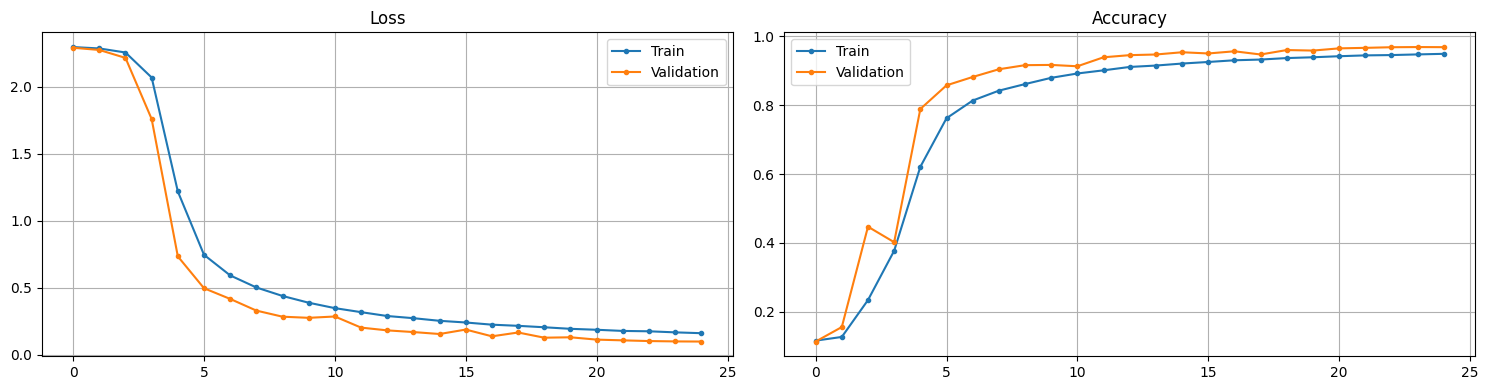

In [26]:
# NOTE: Plotting training and validation performance for comparison
# Create subplots for loss and accuracy comparison
fig, axes = plt.subplots(ncols=2, figsize=(15, 4))

# Plot training and validation losses
axes[0].plot(np.arange(len(train_losses)), train_losses, ".-")
axes[0].plot(np.arange(len(valid_losses)), valid_losses, ".-")
axes[0].legend(["Train", "Validation"])
axes[0].set_title("Loss")  # Set title for the loss subplot
axes[0].grid()  # Add grid lines to the plot

# Plot training and validation accuracies
axes[1].plot(np.arange(len(train_accuracies)), train_accuracies, ".-")
axes[1].plot(np.arange(len(valid_accuracies)), valid_accuracies, ".-")
axes[1].legend(["Train", "Validation"])
axes[1].set_title("Accuracy")  # Set title for the accuracy subplot
axes[1].grid()  # Add grid lines to the plot

# Show the plots
fig.tight_layout()
plt.show()

**TODO:**


Write here about model architectures you've tried, it's metrics, and intuition why something worked and something don't.

## "Default" model with completed TODO

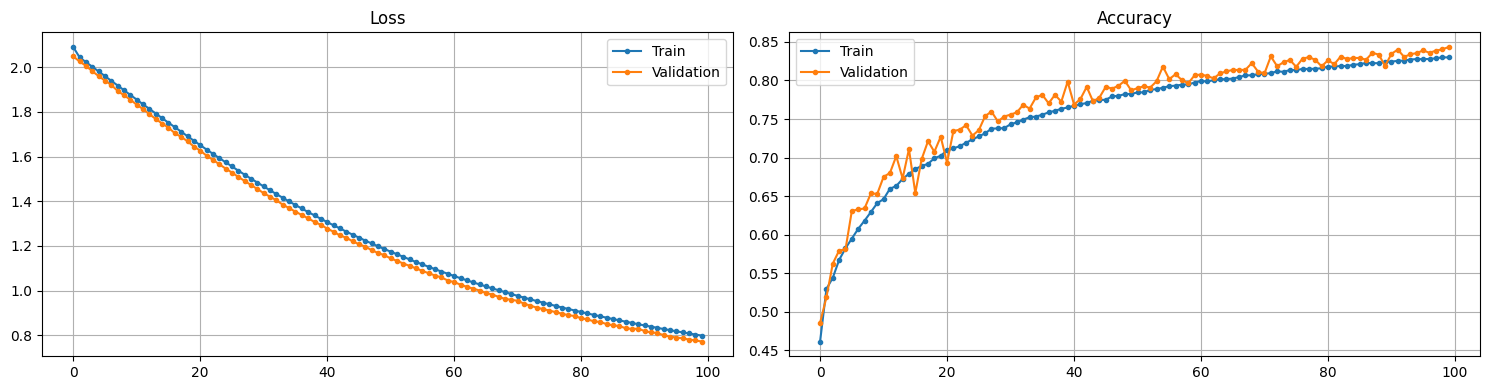
---

Nothing fancy, behaviour as expected

## Linear model based on the "default" but with dropout & normalization layers

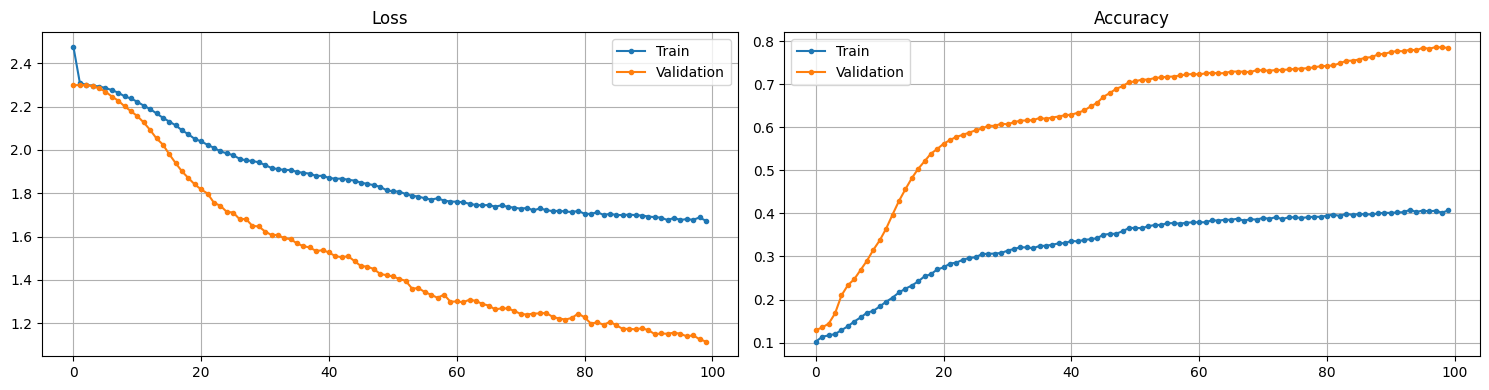

---

Difference in Train/Validation is expected, as dropout layers are normalization layers & are not applied at model.eval(), but generally new layers introduced robustness to the model.

General score is a bit smaller than standard one, but the difference between Train/Validation also increases (what suggests effectivenes of dropout & potential better scores in the next epochs), so potentail solution - more training epochs + hyperparameters tuning.

## CNN with Adam optimizer | 3 convolutional layers (1→32→32→64) and 2 fully connected layers (256→10). Weight initialization using He (Kaiming) uniform initialization <br>
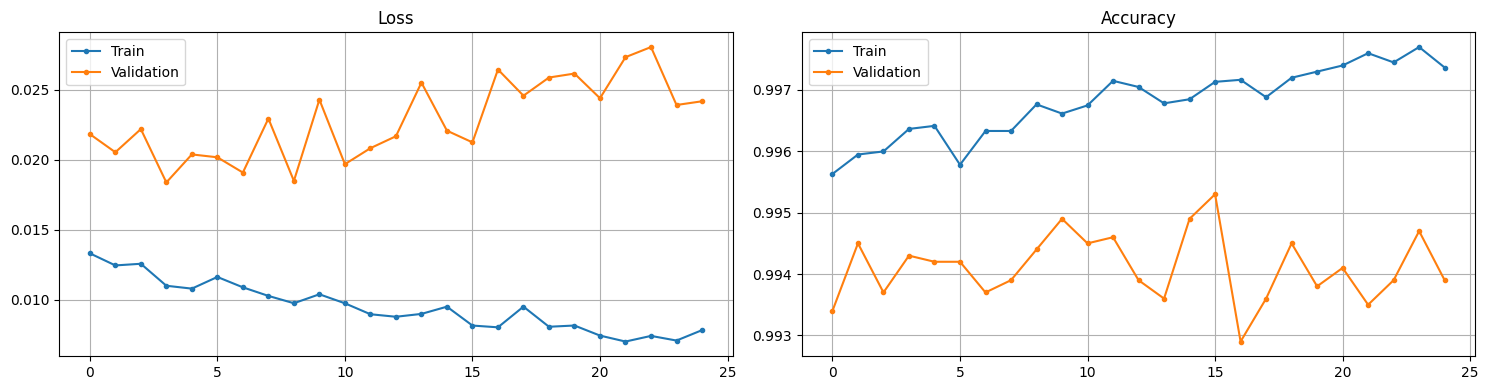

---
## CNN with SGD optimizer | 3 convolutional layers (1→32→32→64) and 2 fully connected layers (256→10). Weight initialization using He (Kaiming) uniform initialization <br>

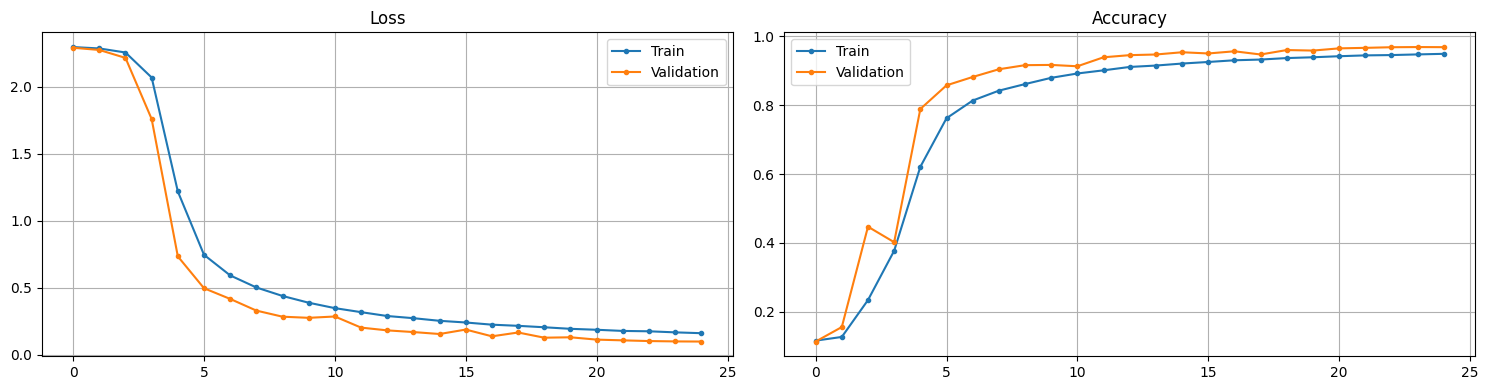

---
**[Adam CNN]** Fluctuating behavior is just the result of low initial loss function & accuracy values & small # of epochs (training time & no further need in our case). From theory I also see hyperparameters tuning & AMSGrad application can provide more stable learning results.

**SGD vs Adam** We cannot explore all the benefits of SGD (i.e. smaller # of hyperparameters to tune, faster, better generalization over big # of epochs), but it works well for linear models. On the other hand, Adam indeed converged faster initially, especially in CNN, what aligns with expectations => "go-to" is SGD, especially for linear, for CNN it can be beneficial to test Adam/AMSGrad.

In both CNN cases, I had to apply Kaiming uniform initialization because without it I assume ReLU was working with initial weights the way that models stuck at ~10% accuracy.

At the same time, CNNs are did really well with images (as was expected from the theory).

For forward propagation I also used `log_softmax` for numerical stability (log-probabilities for each class) - it was used in tutorial & did well here. After I discovered that it is not recommended to run it with `CrossEntropyLoss` and it is better to use something like `NLLLoss`, but our objective is to test & play around (and it works), so I left it as-is.

## Other parameters

I played a bit with `torchvision.transforms` for dataset augmentation, but because lack of time of proper "human" integration & lack of time (training, interpretation, "bloated" code) decided not to use it here.

**Learning rate** is just another hyperparameter which requires to be found - not to small, not to big. The initial value 1e-3 is "default recommended" & it worked well in our case.